# 5MA Sujet de projet

# Transfert d'organe sous incertitude sur la compatibilité

## Introduction

Malgré l'augmentation croissante du nombre de transplantations d'organes effectuées chaque année (environ 6000 en 2017 dont 3782 transplantations de reins), la demande reste en perpétuelle augmentation. Ainsi 6000 organes, dont 3782 reins, ont été transplantés en 2017, mais il y avait encore 24000 personnes en attente d'un organe la même année. Les organes transplantés peuvent provenir d'un donneur décédé ou, dans le cas des reins et du foie, d'un donneur vivant consentant, le plus souvent membre de la famille du patient. Hélas, même si un proche accepte de prendre ce risque pour sa santé, il ne sera pas forcément compatible avec le patient. Pour cette raison, les pratiques médicales les législations évoluent dans de nombreux pays afin de permettre la mise en place d'un programme d'échange de dons d'organes.

L'exemple le plus simple d'échange de don d'organes est celui où deux patients $P_1$ et $P_2$ sont accompagnés de donneurs $D_1$ et $D_2$. Les patients sont supposés incompatibles avec les donneurs qui les accompagnent, mais on suppose que $D_1$ est compatible avec $P_2$ et $D_2$ avec $P_1$. Il est alors possible de transplanter un organe de $D_1$ vers $P_2$ et de $D_2$ vers $P_1$ avec le consentement de tous et en suivant la procédure légale.

Plus généralement, un cycle d'échange d'organes associe $k$ paires de patient-donneur $(P_{i_1},D_{i_1}), \dots, P_{i_k},D_{i_k})$ de sorte que $D_{i_l}$ donne à $P_{i_{l+1}}$ pour $l=1,\dots,k-1$ et $D_{i_k}$ donne à $P_{i_1}$.
Par ailleurs, le point essentiel est que les transferts soient tous réalisés en même temps et dans le même hôpital pour éviter qu'une rétractation de dernière minute ne lèse un patient et son donneur, et que les patients et donneurs venus ensemble et leur famille puissent se soutenir émotionnellement durant l'hospitalisation. 
Pour cette raison, le nombre d'échanges prenant place au sein d'un même cycle est nécessairement limité. En pratique, l'organisation d'un cycle de trois paires est déjà une épreuve pour le personnel d'un hôpital, et le plus grand cycle ayant jamais eu lieu a a impliqué six patients et donneurs.

Dans ce projet, nous prendrons le point de vue de l'organisme national responsable de la gestion du programme d'échange d'organes. 
À chaque phase d'échange, l'objectif de cet organisme est de choisir un ensemble de cycles d'échanges entre paires compatibles afin de maximiser le nombre de patients recevant un organe. Dans certains cas, on peut aussi donner une priorité à certains patients en fonction de la gravité de leur état ou de la durée de leur attente. 
Pour cela, on pourra attribuer des poids différents à chaque patient et maximiser la somme des poids des patients recevant un organe. 

Lors d'une première phase de planification, l'organisme ne dispose que de données individuelles sur chaque donneur et chaque receveur pour déduire la compatibilité entre donneurs et patients. 
Ces données sont principalement le groupe sanguin et le complexe majeur d’histocompatibilité, aussi appelé système HLA. 
Ils en tirent un premier graphe de compatibilité orienté, $G=(V,A)$, où chaque sommet de $V$ représente une paire donneur-patient et où un arc entre deux paires $(P_k,D_k)$ et $(P_l,D_l)$ signifie que $D_k$ est __a priori__ compatible avec $P_l$.
Cependant, la compatibilité effective entre deux personnes ne peut être assurée qu'en mettant en présence des tissus des deux personnes dans ce que l'on appelle un _test croisé_. 
En général, on peut supposer que les données individuelles permettent de déterminer une probabilité de réussite du test croisé.
Mais, dans tous les cas, ces tests peuvent être lourds à réaliser pour les patients et demander des ressources importantes aupèrs des services hospitaliers, donc leur nombre sera toujours limité. 
On pourra pour cela considérer une limite fixe, une limite dépendant du nombre de paires patient-donneur ou bien supposer que les tests ne servent qu'à confirmer la compatibilité après avoir décidé les cycles d'échange entre patients a priori compatibles. 


---

Ici on distingue bien un problème de type optimisation sous incertitude. On une décision à priori qui est les cycles que nous choisissons et ensuite nous réalisons des tests. Ces différents tests nous permettront de nous assurer à postériori des différentes compatibilités réelles.

TODO : définir les variables à priori et les variables de recours $x$ seront les variables à priori et $y$ seront les variables de recours


- une première contrainte apparaît ici : on ne veut limiter la longueure des cycles. Si on considère des cycles qui sont trop longs on va avoir des problèmes dans notre mise en place à l'hopital.

- il y aura ensuite tout un ensemble de contraintes qui nous permettront de définir ce que l'on appel des cycles.

## Description des données

Des jeux de données correspondant à des ensembles de paires patient-donneur ont été partagés dans la PrefLib (https://www.preflib.org/data/MD). Le sous-ensemble d'instances auxquels vous pourrez vous intéresser dans un premier temps accompagne ce sujet sur Moodle. Les dix premières instances (numérotées de 1 à 10) contiennent 10 paires patient-donneur, les 10 suivantes (numérotées de 31 à 40) en contiennent 32 et les 10 dernières (numérotées de 71 à 80) en contiennent 64. Chaque jeu de données est décrit par deux fichiers, l'un énumérant les données relatives à chaque paire et portant l'extension .dat, et l'autre énumérant les données relatives aux arcs et portant l'extension .wmd.
Nous vous fournissons une fonction permettant de lire les fichiers relatifs à un jeu de donnéees. 

Une fois le graphe de compatibilité donné, une instance est entièrement décrite par la connaissance de la distribution des incertitudes dans une approche par optimisation stochastique. Dans une approche par optimisation robuste, le pire cas est déjà connu pour chaque arête, il s'agit d'un échec de la transplantation. Plusieurs modèles d'incertitudes sont classiquement regardés dans la littérature, mais tous considèrent que la réussite du test croisé réalisé sur un arc $a$ suit une loi de Bernouilli de probabilité $1-f_a$ où $f_a$ est une probabilité d'échec donnée. Nous donnons ci-dessous la fonction permettant de calculer des probabilités d'échec pour tous les arcs en fonction d'un paramètre à choisir dans le tableau DISTRIBUTIONS.

---

Sur chaque arrète on va avoir la probabilité que le transplantation soit réussit ou pas.

## Travail à réaliser

Nous vous donnons une grande liberté sur la façon de traiter le sujet. En fonction de décisions que vous justifierez, vous pourrez traiter le problème par une approche d'optimisation stochastique, d'optimisation robuste ou de toute autre approche averse aux risques. Le travail commencera par décrire l'approche suivie puis le modèle en découlant. Un code Julia permettra ensuite d'implémenter une ou plusieurs méthodes de résolution pour le modèle. Vous pourrez tester la ou les méthodes sur des instances de la PrefLib. Vos interprétations devront rendre compte des enjeux pratiques et des enjeux algorithmiques (optimalité, temps de calcul, passage à l'échelle, etc.) de votre travail.
Le résultat de votre travail sera à rendre dans ce notebook avant le 14 janvier 2022. Chaque cellule du notebook aura préalablement été exécutée (sans erreur, évidemment), et il importera que les affichages utilisés dans vos interprétations y apparaissent. 

In [2]:
"""
check that here the path ends with `KidneyExchangeProgram`, the git name
"""

while(last(split(pwd(), Base.Filesystem.path_separator)) != "KidneyExchangeProgram")
    cd("..")
end
println(pwd())

C:\Users\baptc\Documents\GM\INSA\3A\S9\Optimisation sous incertitudes\KidneyExchangeProgram


In [16]:
using Random, MetaGraphs, SimpleWeightedGraphs, Graphs, JuMP, DelimitedFiles, Distributions, Plots, GraphPlot

# include files for the data reading and data extraction
include(join(["utils", "graph_extraction.jl"], Base.Filesystem.path_separator))
include(join(["utils", "data_reading.jl"], Base.Filesystem.path_separator))

# include files for the modeling and solving part
## stochastic optimization
include(join(["src", "stochastic_framework", "master_problem.jl"], Base.Filesystem.path_separator))
#include(join(["src", "stochastic_framework", "recourse_problem.jl"], Base.Filesystem.path_separator))


# for the random simulations
include(join(["utils", "monte_carlo.jl"], Base.Filesystem.path_separator))

# for displaying the solution
include(join(["utils", "visualization.jl"], Base.Filesystem.path_separator))
    
# for solution extraction
include(join(["utils", "solution_extraction.jl"], Base.Filesystem.path_separator))

getClusterUsefull

## Les données

Nous allons travailler ici avec des données sous forme de graphes. Les fonctions `read_kep_file` et `get_failure_rates` du fichier `.\utils\data_reading.jl` nous permettent de lire les fichier de données correspondant au problème de construire le graphe correspondant et ensuite de venir calculer les probabilités d'échec (du test croisé) de chaque arc. Voici un exemple d'utilisation des deux premières fonctions :

In [8]:
kep_graph = read_kep_file("./_cache/data/MD-00001-00000080.wmd","./_cache/data/MD-00001-00000080.dat");
failure_rates = get_failure_rates(kep_graph, "Constant");

La fonction `extractCycleInformation` du fichier `.\utils\graph_extraction.jl`, nous permettra de venir extraire des données du graph crée. Cette fonction est orienté sur les cycles.

In [4]:
print(@doc(extractCycleInformation))

```
extractCycleInformation
```

This function allow us to extract the relevant information from the kep*graph. The relevant information here concern the cycle formulation of the kep*graph.

# Parameters

  * `g` : the kep_graph
  * `K` (int): the length of the Cycles
  * `mode`: the method to use to compute the calculus of the utilities

# Return

This function returns a Julia dictionnary with the following keys :

  * `Cycles_index` : a list of integer each element of the list corresponds to the index of a cycle
  * `vertic_cycles` : a dictionnary with vertices as keys and a list of cycles which involve the key as value
  * `Cycles` : the exhaustive enumeration of the cycles
  * `P` : for each cycle, the probability of failure. To get the success do 1 - ...
  * `U` : the utility of each cycle


In [5]:
extract_data = extractCycleInformation(kep_graph, 3, "sum");

## Un problème (presque) à recourt

Notre première vision de ce problème était de réfléchir uniquement sur les cycles. Nous adoptons la philosophie qui consiste à dire que on sélectionne des cycles et nous ne réalisons les tests croisés que parmis les cycles que nous avons sélectionnés

On définit ainsi les données suivantes :

- $C$ : l'ensemble des cycles de longueurs au plus $K$
- $\forall c \in C \quad w_c$ : désignera l'utilité du cycle $c$
- $\forall ~c~\in C\quad \xi_c(\omega) \in \{0, 1\} = 1$ : si et seulement si on ne peut pas sélectionner le cycle $c$ (les tests sont mauvais) pour la réalisation $\omega$

On définit les variables suivantes

- $1^{er}$ niveau : $\forall c \in C\quad x_c \in \{0, 1\} = 1$ si et seulement si, on décide de sélectionner le cycle $c$.
- recours : $\forall c \in C\quad y_c \in \{0, 1\} = 1$ on ne peut pas sélectionner le cycle $c$ suite à la réalisation des tests.

$$
\begin{equation}
	(\mathbb{CRP}) := \left\{\begin{aligned}
        \underset{x}{\min} \quad & - \sum_{c \in C} x_cw_c +\mathbb{E}\left(\underset{y}{\min} \left[\sum_{c \in C} y_cw_c\right]\right)\\
         s.c \quad &\sum_{c\in C_i}x_c\leq 1~\forall i \in V\\ % contrainte déterministe
         % les contraintes stochastiques
         & y_c = \xi_c(\omega)~x_c\quad \forall c \in C \quad \forall \omega \in \Omega\\ 
         & x_c \in \{0,1\} \quad \forall c \in C\\
         & y_c \in \{0,1\} \quad \forall c \in C
	\end{aligned}\right.
\end{equation}
$$

Nous pouvons ainsi reformuler ce problème de la façon suivante :

$$
\begin{equation}
	(\mathbb{CRP}) := \left\{\begin{aligned}
        \underset{x}{\min} \quad & - \sum_{c \in C} x_cw_c +\mathbb{E}\left( \left[\sum_{c \in C} \xi_cx_cw_c\right]\right)\\
         s.c \quad &\sum_{c\in C_i}x_c\leq 1~\forall i \in V\\ % contrainte déterministe
         & x_c \in \{0,1\} \quad \forall c \in C\\
	\end{aligned}\right.
\end{equation}
$$

Nous obtenons finalement :

$$
\begin{equation}
	(\mathbb{CRP}) := \left\{\begin{aligned}
        \underset{x}{\min} \quad & \sum_{c \in C} x_cw_c(\mathbb{E} \left[ \xi_c\right] - 1)\\
         s.c \quad &\sum_{c\in C_i}x_c\leq 1~\forall i \in V\\ % contrainte déterministe
         & x_c \in \{0,1\} \quad \forall c \in C\\
	\end{aligned}\right.
\end{equation}
$$

Avec $\mathbb{E}[\xi_c] = \mathbb{P}\{\xi_c = 1\}$ d'où $\mathbb{E}[\xi_c] - 1 = -\mathbb{P}\{\xi_c = 0\}$


Ainsi nous avons :

$$
\begin{equation}
	(\mathbb{CRP}) := \left\{\begin{aligned}
        \underset{x}{\max} \quad & \sum_{c \in C} x_cw_c(\mathbb{P}\{\xi_c = 0\})\\
         s.c \quad &\sum_{c\in C_i}x_c\leq 1~\forall i \in V\\ % contrainte déterministe
         & x_c \in \{0,1\} \quad \forall c \in C\\
	\end{aligned}\right.
\end{equation}
$$


Ainsi nous pourrons note $\tilde{w}_c = w_c \times \mathbb{P}\{\xi_c = 0\}$, la nouvelle utilité d'un cycle qui sera en faite une combinaison entre l'utilité réelle du cyle $w_c$ et la probabilité que ce dernier se réalise. Nous pouvons ici que un cycle avec $w_c$ grand mais une probabilité de succés très faible aura peu de chance d'être choisi. En effet pourquoi choisir ce cycle si on sait qu'il n'a aucune chance (ou presque) de se réaliser.

Nous avons finalement le problème suivante :

$$
\begin{equation}
	(\mathbb{CRP}) := \left\{\begin{aligned}
        \underset{x}{\max} \quad & \sum_{c \in C} x_c\hat{w}_c\\
         s.c \quad &\sum_{c\in C_i}x_c\leq 1~\forall i \in V\\ % contrainte déterministe
         & x_c \in \{0,1\} \quad \forall c \in C\\
	\end{aligned}\right.
\end{equation}
$$

Nous pouvons voir ainsi que ce problème $\mathbb{CRP}$ est donc un problème totalement déterministe. Nous proposons la méthode `completRecourseProblem` dans le fichier `dtm_framework/complete_recourse.jl`. Pour résoudre ce dernier. Cette dernière fonction possède la signature suivante :

In [5]:
include(join(["src", "dtm_framework", "complete_recourse.jl"], Base.Filesystem.path_separator))
print(@doc(completRecourseProblem))

```
completRecourseProblem
```

This is the deterministic version of the problem with the complete recourse.

# Parameters

  * `C` : index of the cycles
  * `vertic_cycles` : a dictionnary, at the key i of this list, give the a list of the index of the cycles which involve the node i
  * `U` : the utilities of each cycle in the graph.
  * `S_P` : probability of sucess of each cycle


In [10]:
# the data
kep_graph = read_kep_file("./_cache/data/MD-00001-00000080.wmd","./_cache/data/MD-00001-00000080.dat");
failure_rates = get_failure_rates(kep_graph, "Constant");
data = extractCycleInformation(kep_graph, 3, "sum");

# the model
res = completRecourseProblem(data["Cycles_index"], data["vertic_cycles"], data["U"], 1 .-data["P"]);
model = res["model"]

optimize!(model)

solution = value.(model[:x])
;

## La méthode des clusters

TODO : présenter le nouveau problème de façon théorique.

In [11]:
# the data
kep_graph = read_kep_file("./_cache/data/MD-00001-00000001.wmd","./_cache/data/MD-00001-00000001.dat");
failure_rates = get_failure_rates(kep_graph, "Constant");
data = extractCycleInformation(kep_graph, 3, "sum");

In [12]:
data

Dict{String, Any} with 5 entries:
  "vertic_cycles" => Dict{Any, Any}(5=>Any[], 16=>Any[], 12=>Any[], 8=>Any[2], …
  "Cycles"        => [[1, 6], [3, 8]]
  "U"             => Any[2, 2]
  "P"             => Any[0.3759, 0.3759]
  "Cycles_index"  => [1, 2]

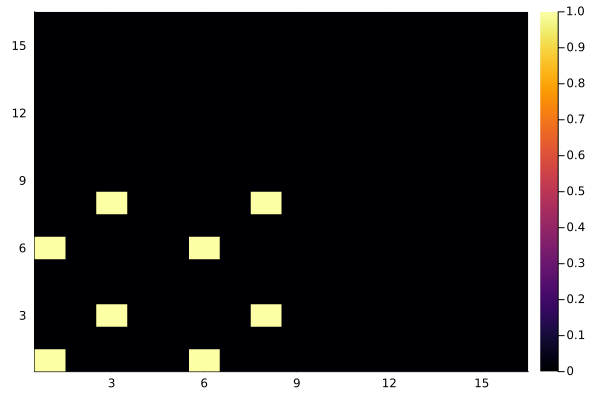

In [13]:
res = masterClusterProblem(kep_graph, 4, data["Cycles_index"], data["Cycles"], data["U"], data["vertic_cycles"])

optimize!(res["model"])
sol = value.(res["model"][:x])

gr()
heatmap(1:size(sol, 1), 1:size(sol, 2), sol)

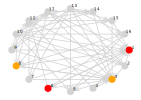

In [17]:
plotSolutionCluster(kep_graph, getClusterUsefull(getCluster(kep_graph, sol)))